In [7]:
library(tidyverse)
library(GenomicRanges)
library(bdkn)
library(glue)
library(future)
library(furrr)
library(slimr)

plan(multiprocess)


Attaching package: ‘glue’

The following object is masked from ‘package:GenomicRanges’:

    trim

The following objects are masked from ‘package:IRanges’:

    collapse, trim

The following object is masked from ‘package:dplyr’:

    collapse



In [3]:
slim_file <- read_slim("../data/burnins/exon_h_0.5.txt")

In [4]:
(muts <- read_mutations(slim_file, mut_type = "m0", time = 70000) %>%
    mutate(chrom = 1, start = pos - 1, end = pos) %>%
    makeGRangesFromDataFrame(starts.in.df.are.0based = TRUE, keep.extra.columns = TRUE))

GRanges object with 171138 ranges and 9 metadata columns:
           seqnames    ranges strand |    mut_id     run_id    mut_type
              <Rle> <IRanges>  <Rle> | <integer>  <integer> <character>
       [1]        1  69120237      * |      5693 1032682955          m0
       [2]        1  52098146      * |    212975 1032741310          m0
       [3]        1  25926279      * |    185894 1032741508          m0
       [4]        1  56180170      * |    216184 1032757997          m0
       [5]        1  67482801      * |    223966 1032773923          m0
       ...      ...       ...    ... .       ...        ...         ...
  [171134]        1  13669447      * |    241851 1321564420          m0
  [171135]        1  24574995      * |    241854 1321564421          m0
  [171136]        1  50528198      * |    241857 1321564422          m0
  [171137]        1  22516933      * |    241863 1321564423          m0
  [171138]        1  23346860      * |    241864 1321564424          m0
      

In [5]:
exons <- read_coordinates("../data/slim_coords/exon_regions.bed")
exons

GRanges object with 217357 ranges and 3 metadata columns:
           seqnames            ranges strand |  real_chrom real_start  real_end
              <Rle>         <IRanges>  <Rle> | <character>  <integer> <integer>
       [1]        1             0-917      * |        chr1      69090     70008
       [2]        1          919-1820      * |        chr1     134900    135802
       [3]        1         1822-3580      * |        chr1     137620    139379
       [4]        1         3582-4576      * |        chr1     367639    368634
       [5]        1         4578-5572      * |        chr1     621058    622053
       ...      ...               ...    ... .         ...        ...       ...
  [217353]        1 74080327-74080356      * |       chr22   51216379  51216409
  [217354]        1 74080358-74080463      * |       chr22   51219040  51219146
  [217355]        1 74080465-74080628      * |       chr22   51220615  51220779
  [217356]        1 74080630-74081147      * |       chr22   5

In [6]:
(hits <- findOverlaps(exons, muts))

Hits object with 171138 hits and 0 metadata columns:
           queryHits subjectHits
           <integer>   <integer>
       [1]         1      127292
       [2]         1       26778
       [3]         1      110846
       [4]         2      123216
       [5]         2      139191
       ...       ...         ...
  [171134]    217349      170355
  [171135]    217350       80375
  [171136]    217350        3452
  [171137]    217351      111887
  [171138]    217356      134354
  -------
  queryLength: 217357 / subjectLength: 171138

In [7]:
mut_counts <- queryHits(hits) %>% table %>% as.data.frame %>% .[["Freq"]]

In [8]:
table(mut_counts)

mut_counts
    1     2     3     4     5     6     7     8     9    10    11    12    13 
46769 13504  5087  2868  1858  1315  1022   807   626   445   360   308   239 
   14    15    16    17    18    19    20    21    22    23    24    25    26 
  222   140   114    93    79    60    44    46    36    25    30    19     7 
   27    28    29    30    31    32    33    34    35    36    37    38    39 
   17    13     9    10     7     6    11     5     2     1     1     2     1 
   40    43    44    46    47    49    50    52    53    57    60 
    1     1     1     1     1     2     1     2     1     1     1 

In [9]:
sum_s <- split(muts[subjectHits(hits)]$s, queryHits(hits)) %>% sapply(sum)

In [10]:
exons_with_muts <- exons[unique(queryHits(hits))]

In [11]:
exons_with_muts$s <- sum_s

In [12]:
exons_with_muts

GRanges object with 76221 ranges and 4 metadata columns:
          seqnames            ranges strand |  real_chrom real_start  real_end
             <Rle>         <IRanges>  <Rle> | <character>  <integer> <integer>
      [1]        1             0-917      * |        chr1      69090     70008
      [2]        1          919-1820      * |        chr1     134900    135802
      [3]        1         1822-3580      * |        chr1     137620    139379
      [4]        1         3582-4576      * |        chr1     367639    368634
      [5]        1         4578-5572      * |        chr1     621058    622053
      ...      ...               ...    ... .         ...        ...       ...
  [76217]        1 74076561-74077934      * |       chr22   51205928  51207302
  [76218]        1 74078150-74078261      * |       chr22   51208332  51208444
  [76219]        1 74078263-74080162      * |       chr22   51209637  51211537
  [76220]        1 74080164-74080244      * |       chr22   51214198  5121

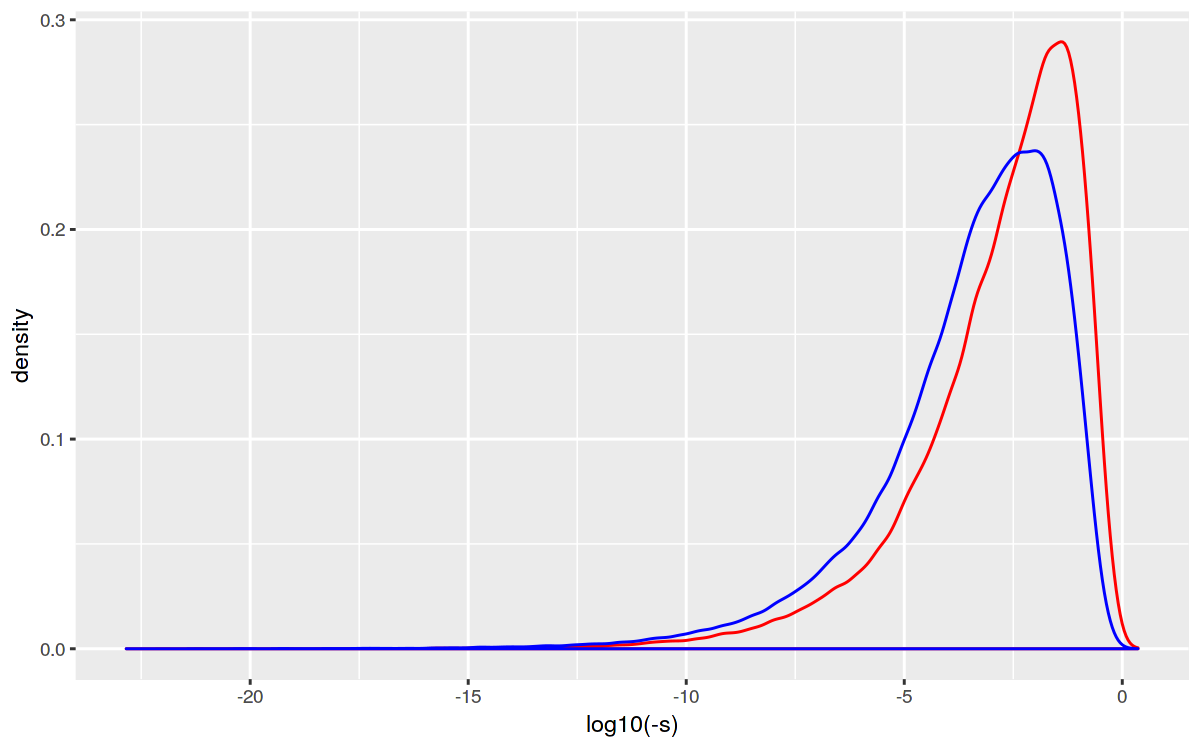

In [13]:
set_dim(8, 5)
ggplot() +
    geom_density(data = as.data.frame(exons_with_muts), aes(log10(-s)), color = "red") +
    geom_density(data = as.data.frame(muts), aes(log10(-s)), color = "blue")

In [14]:
exons_with_muts$bin <- bin_quantiles(exons_with_muts$s, n = 5, labels = TRUE)

In [15]:
exons_with_muts

GRanges object with 76221 ranges and 5 metadata columns:
          seqnames            ranges strand |  real_chrom real_start  real_end
             <Rle>         <IRanges>  <Rle> | <character>  <integer> <integer>
      [1]        1             0-917      * |        chr1      69090     70008
      [2]        1          919-1820      * |        chr1     134900    135802
      [3]        1         1822-3580      * |        chr1     137620    139379
      [4]        1         3582-4576      * |        chr1     367639    368634
      [5]        1         4578-5572      * |        chr1     621058    622053
      ...      ...               ...    ... .         ...        ...       ...
  [76217]        1 74076561-74077934      * |       chr22   51205928  51207302
  [76218]        1 74078150-74078261      * |       chr22   51208332  51208444
  [76219]        1 74078263-74080162      * |       chr22   51209637  51211537
  [76220]        1 74080164-74080244      * |       chr22   51214198  5121

In [16]:
table(exons_with_muts$bin)


    1     2     3     4     5 
15245 15244 15244 15244 15244 

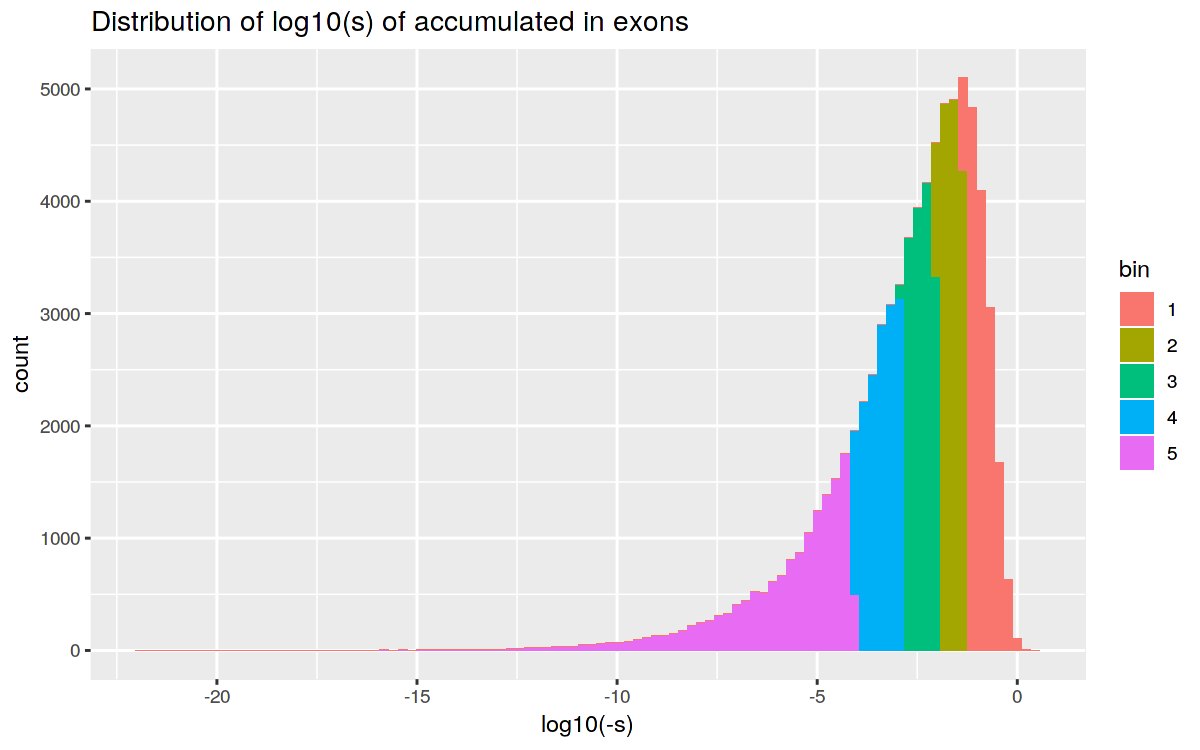

In [17]:
as.data.frame(exons_with_muts) %>% 
ggplot(aes(log10(-s), fill = bin)) + geom_histogram(bins=100) +
    ggtitle("Distribution of log10(s) of accumulated in exons")

In [27]:
region <- "exon"

# load the table of coordinates (real and SLiM-based) of fixed markers (both within and outside selected regions)
all_sites <- read_coordinates(paste0("../data/slim_coords/", region, "_all_sites.bed"))

bin_props <- mclapply(1:20, mc.cores = 20, function(rep) {

bins <- map_dfr(unique(exons_with_muts$bin), function(b) {

    trans_regions <- exons_with_muts[exons_with_muts$bin == b]
    bin_regions <- transpose_coordinates(trans_regions, trans_regions)

    vcf <- read_vcf(paste0("../data/simulations/delta_constant_", region, "_h_0.5_rep_", rep, "_gen_", 2200, ".vcf.gz"))

    trans_markers <- mut_gt(vcf, mut_type = 1) %>% fill_lost(all_sites) %>% transpose_coordinates(all_sites)

    inside_markers  <- trans_markers[trans_markers %within% bin_regions]
    outside_markers  <- trans_markers[! trans_markers %within% trans_regions]

    inside <- mcols(inside_markers) %>%
        as.data.frame %>%
        mutate(bin = b) %>%
        mutate(rep = rep) %>%
        select(rep, freq, bin, starts_with("chr"))
    
    outside <- mcols(outside_markers) %>%
        as.data.frame %>%
        mutate(bin = paste0("out_", b)) %>%
        mutate(rep = rep) %>%
        select(rep, freq, bin, starts_with("chr"))
    
    bind_rows(inside, outside)

})

group_by(bins, bin) %>%
    summarise_at(vars(starts_with("chr")), mean) %>%
    gather(chr, nea_prop, -bin) %>%
    ungroup %>% 
    mutate(bin = factor(bin))

}) %>% bind_rows

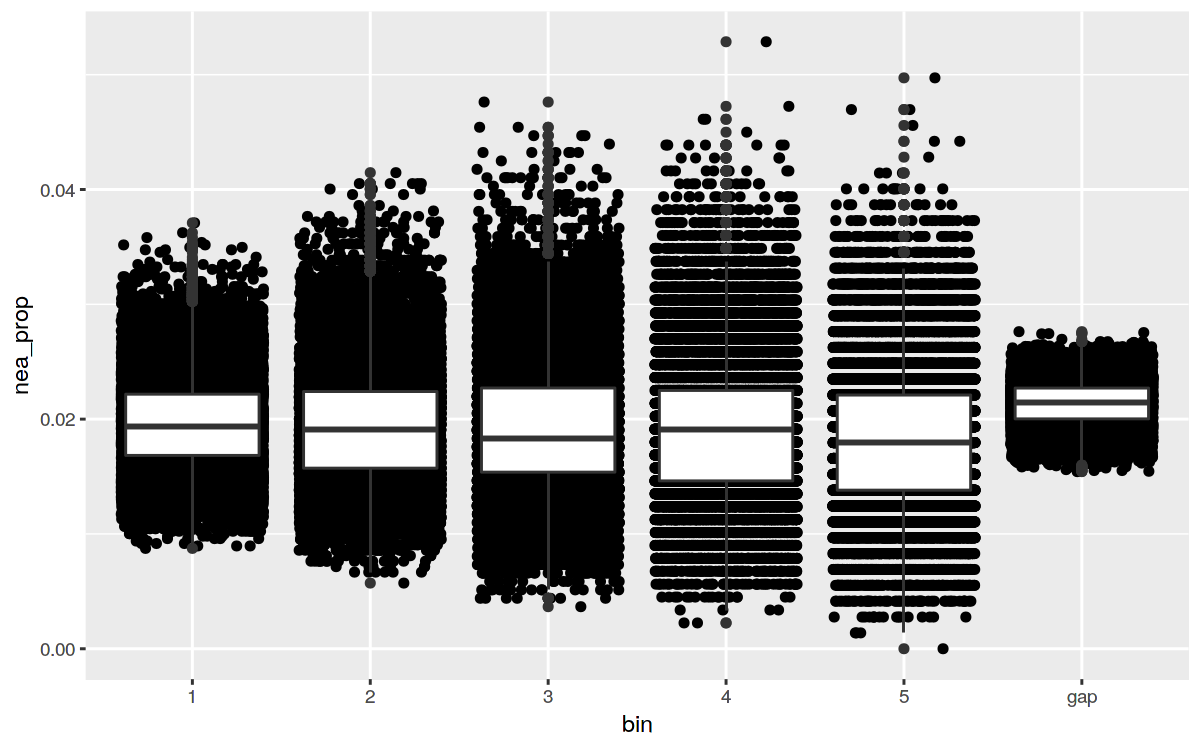

In [28]:
bin_props %>% filter(bin %in% 1:5 | bin == "out_1") %>% mutate(bin = str_replace(bin, "out_1", "gap")) %>%
ggplot(aes(bin, nea_prop)) + geom_jitter() + geom_boxplot()

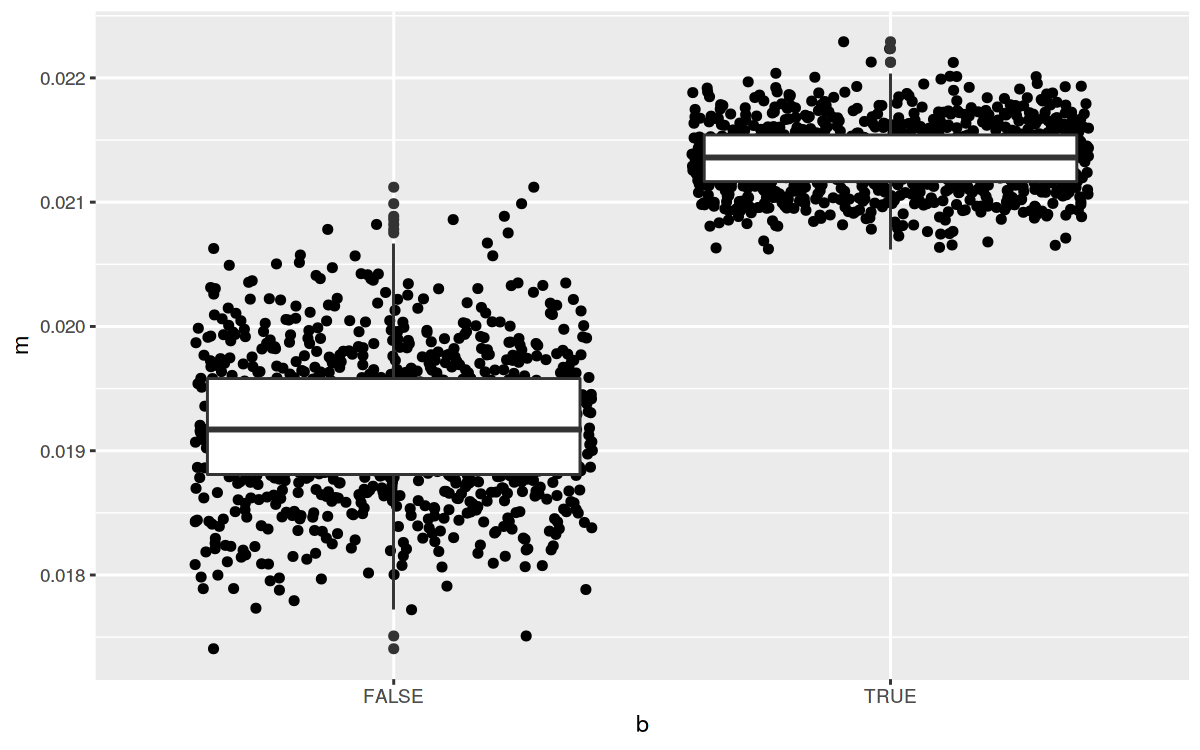

In [24]:
bin_props %>% filter(bin %in% 1:5 | bin == "out_1") %>% mutate(bin = str_replace(bin, "out_1", "gap")) %>%
mutate(b = bin == "gap") %>%
group_by(b, chr) %>% 
summarise(m = mean(nea_prop)) %>%
ggplot(aes(b, m)) + geom_jitter() + geom_boxplot()

In [105]:
s_exons <- read_coordinates("../data/slim_coords/bin_s_exon_regions.bed")

In [106]:
s_exons <- transpose_coordinates(s_exons, s_exons)

In [42]:
region <- "exon"

# load the table of coordinates (real and SLiM-based) of fixed markers (both within and outside selected regions)
all_sites <- read_coordinates(paste0("../data/slim_coords/", region, "_all_sites.bed"))

s_bin_props <- mclapply(1:50, mc.cores = 20, function(rep) {

bins <- map_dfr(sort(unique(s_exons$bin_s)), function(b) {

    bin_regions <- exons[s_exons$bin_s == b]

    vcf <- read_vcf(paste0("../data/simulations/", region, "_bin_s_rep_", rep, "_gen_", 2200, ".vcf.gz"))

    trans_markers <- mut_gt(vcf, mut_type = 1) %>% fill_lost(all_sites) %>% transpose_coordinates(all_sites)

    inside_markers  <- trans_markers[trans_markers %within% bin_regions]
    outside_markers  <- trans_markers[! trans_markers %within% exons]

    inside <- mcols(inside_markers) %>%
        as.data.frame %>%
        mutate(bin = as.character(b)) %>%
        mutate(rep = rep) %>%
        select(rep, freq, bin, starts_with("chr"))
    
    outside <- mcols(outside_markers) %>%
        as.data.frame %>%
        mutate(bin = paste0("out_", b)) %>%
        mutate(rep = rep) %>%
        select(rep, freq, bin, starts_with("chr"))
    
    bind_rows(inside, outside)

})

group_by(bins, bin) %>%
    summarise_at(vars(starts_with("chr")), mean) %>%
    gather(chr, nea_prop, -bin) %>%
    ungroup %>% 
    mutate(bin = factor(bin))

}) %>% bind_rows

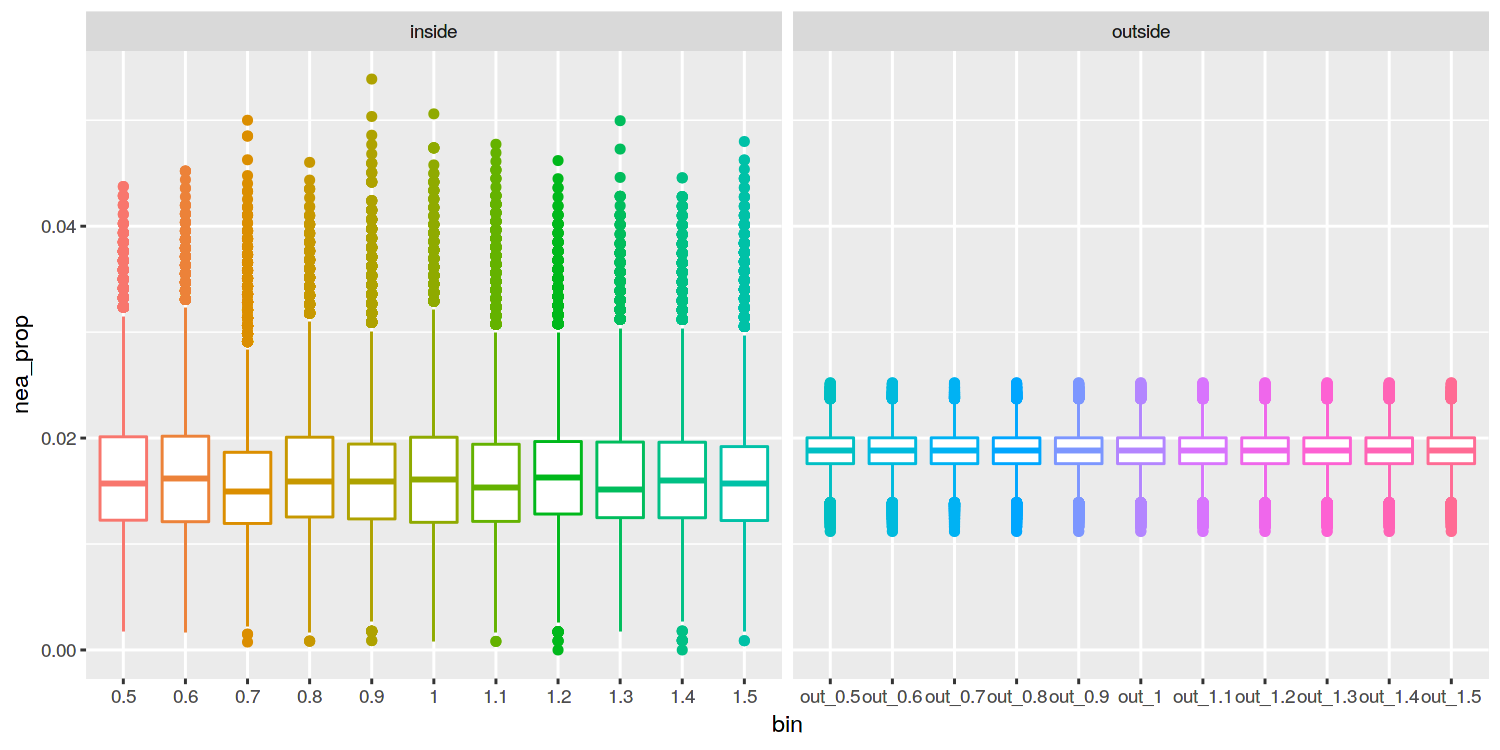

In [54]:
set_dim(10, 5)

s_bin_props %>% mutate(part = ifelse(str_detect(bin, "out"), "outside", "inside")) %>% 
mutate(bin = as.character(bin)) %>% 
ggplot(aes(bin, nea_prop, color = bin)) + geom_boxplot() + theme(legend.position = "none") +
facet_wrap(~ part, scales = "free_x")

In [66]:
exons <- read_coordinates("../data/slim_coords/bin_h_exon_regions.bed")

In [67]:
exons <- transpose_coordinates(exons, exons)

In [69]:
region <- "exon"

# load the table of coordinates (real and SLiM-based) of fixed markers (both within and outside selected regions)
all_sites <- read_coordinates(paste0("../data/slim_coords/", region, "_all_sites.bed"))

h_bin_props <- mclapply(1:50, mc.cores = 20, function(rep) {

bins <- map_dfr(sort(unique(exons$bin_h)), function(b) {

    bin_regions <- exons[exons$bin_h == b]

    vcf <- read_vcf(paste0("../data/simulations/", region, "_bin_h_rep_", rep, "_gen_", 2200, ".vcf.gz"))

    trans_markers <- mut_gt(vcf, mut_type = 1) %>% fill_lost(all_sites) %>% transpose_coordinates(all_sites)

    inside_markers  <- trans_markers[trans_markers %within% bin_regions]
    outside_markers  <- trans_markers[! trans_markers %within% exons]

    inside <- mcols(inside_markers) %>%
        as.data.frame %>%
        mutate(bin = as.character(b)) %>%
        mutate(rep = rep) %>%
        select(rep, freq, bin, starts_with("chr"))
    
    outside <- mcols(outside_markers) %>%
        as.data.frame %>%
        mutate(bin = paste0("out_", b)) %>%
        mutate(rep = rep) %>%
        select(rep, freq, bin, starts_with("chr"))
    
    bind_rows(inside, outside)

})

group_by(bins, bin) %>%
    summarise_at(vars(starts_with("chr")), mean) %>%
    gather(chr, nea_prop, -bin) %>%
    ungroup %>% 
    mutate(bin = factor(bin))

}) %>% bind_rows

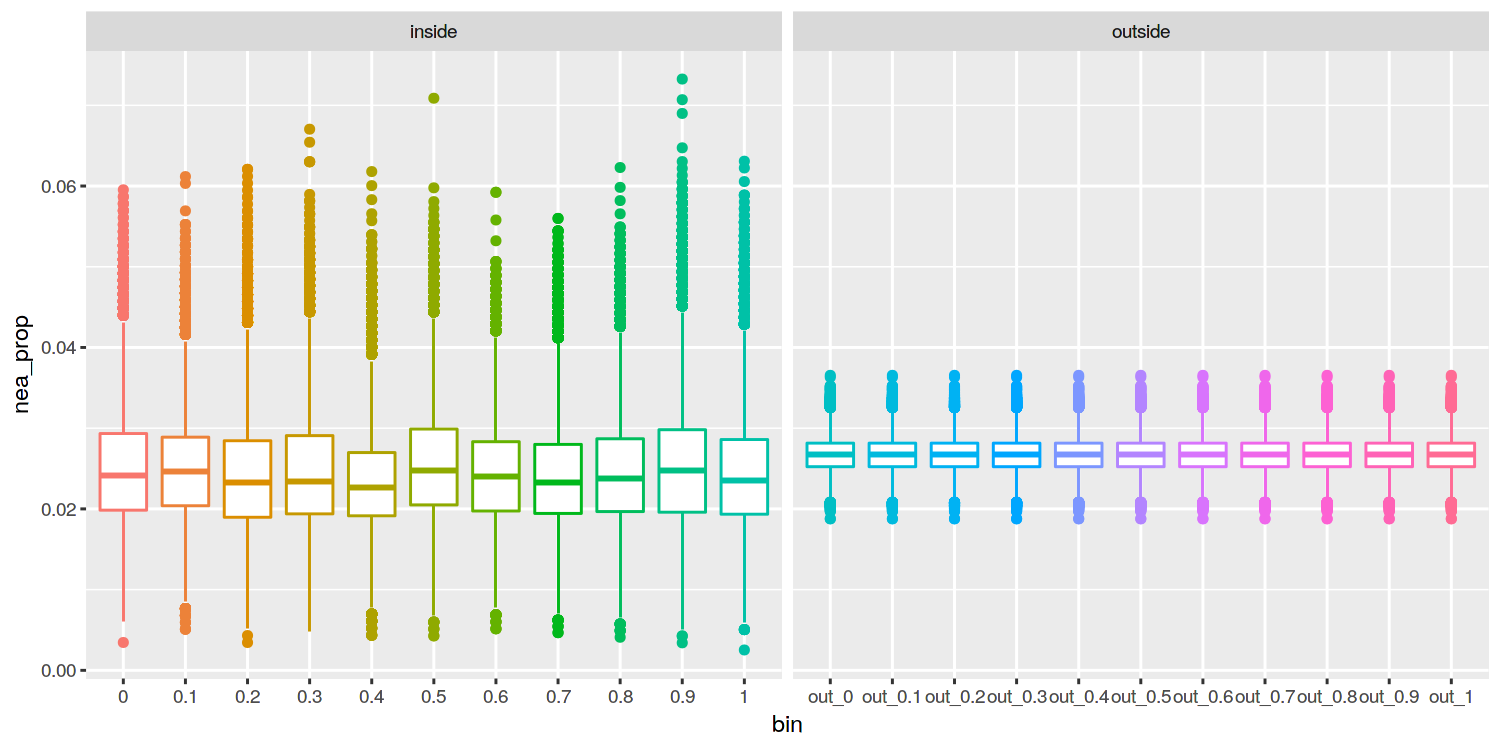

In [70]:
set_dim(10, 5)

h_bin_props %>% mutate(part = ifelse(str_detect(bin, "out"), "outside", "inside")) %>% 
mutate(bin = as.character(bin)) %>% 
ggplot(aes(bin, nea_prop, color = bin)) + geom_boxplot() + theme(legend.position = "none") +
facet_wrap(~ part, scales = "free_x")

## Dominance of promoters differs

In [43]:
all_sites <- read_coordinates("../data/slim_coords/merged_all_sites.bed")

slim_merged <- read_coordinates("../data/slim_coords/merged_regions.bed")

real_promoters <- suppressMessages(read_tsv("../data/slim_coords/promoter_regions.bed")) %>% makeGRangesFromDataFrame(starts.in.df.are.0based = TRUE, keep.extra.columns = TRUE)
real_merged <- suppressMessages(read_tsv("../data/slim_coords/merged_regions.bed")) %>% makeGRangesFromDataFrame(starts.in.df.are.0based = TRUE, keep.extra.columns = TRUE)

hits <- findOverlaps(real_merged, real_promoters)

promoters <- slim_merged[queryHits(hits)]
cds <- slim_merged[slim_merged %outside% promoters]

In [44]:
dominances <- c("0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0")

In [37]:
h_prom_cds <- future_map_dfr(dominances, function(h) {
    
map_dfr(1:20, function(rep) {
    vcf_path <- glue("../data/simulations/merged_dom_{h}_rep_{rep}_gen_2200.vcf.gz")
    
    if (!file.exists(vcf_path)) return(NULL)

    vcf <- read_vcf(vcf_path)

    markers <- mut_gt(vcf, mut_type = 1) %>% fill_lost(all_sites)

    promoter_markers  <- markers[markers %within% promoters] %>% as.data.frame %>% mutate(rep = rep, bin = "promoter") %>% select(rep, freq, bin, starts_with("chr"))
    cds_markers  <- markers[markers %within% cds] %>% as.data.frame %>% mutate(rep = rep, bin = "cds") %>% select(rep, freq, bin, starts_with("chr"))
    gap_markers  <- markers[markers %outside% IRanges::union(cds, promoters)] %>% as.data.frame %>% mutate(rep = rep, bin = "gap") %>% select(rep, freq, bin, starts_with("chr"))

    bind_rows(promoter_markers, cds_markers, gap_markers)

}) %>%
    group_by(bin) %>%
    summarise_at(vars(starts_with("chr")), mean) %>%
    gather(chr, nea_prop, -bin) %>%
    ungroup %>% 
    mutate(bin = factor(bin), dominance = h)

})

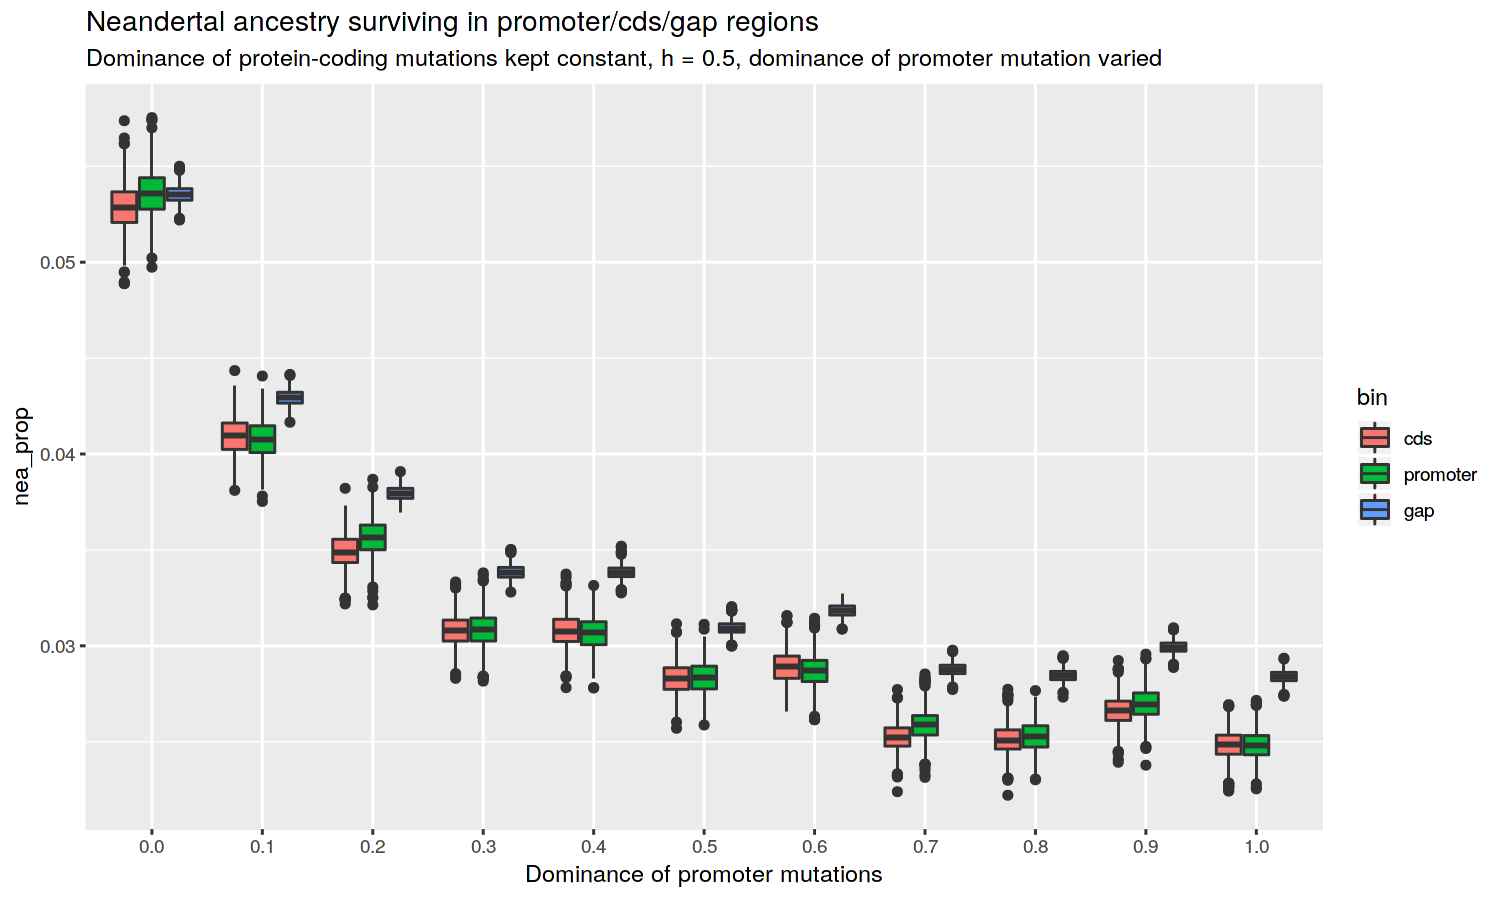

In [38]:
set_dim(10, 6)

h_prom_cds %>%
mutate(dominance = factor(dominance),
       bin = factor(bin, levels = c("cds", "promoter", "gap"))) %>%
ggplot(aes(dominance, nea_prop, fill = bin)) + geom_boxplot() +
    xlab("Dominance of promoter mutations") +
    ggtitle("Neandertal ancestry surviving in promoter/cds/gap regions",
            "Dominance of protein-coding mutations kept constant, h = 0.5, dominance of promoter mutation varied")

Are there really differences in h of deleterious mutations between promoters and CDS (sanity check)?

In [62]:
mut_dominances <- future_map_dfr(dominances, function(h) {
    slim_file <- read_slim(glue("../data/burnins/different_h_{h}_merged.txt"))
    muts <- read_mutations(slim_file) %>%
        filter(mut_type != "m1") %>%
        mutate(chrom = 1, start = pos - 1, end = pos) %>%
        makeGRangesFromDataFrame(starts.in.df.are.0based = TRUE, keep.extra.columns = TRUE)

    bind_rows(
        data.frame(scenario = h, dominances = muts[muts %over% cds]$h, region = "CDS"),
        data.frame(scenario = h, dominances = muts[muts %over% promoters]$h, region = "promoter")
    )
})

In [64]:
head(mut_dominances)

scenario,dominances,region
0.0,0.5,CDS
0.0,0.5,CDS
0.0,0.5,CDS
0.0,0.5,CDS
0.0,0.5,CDS
0.0,0.5,CDS


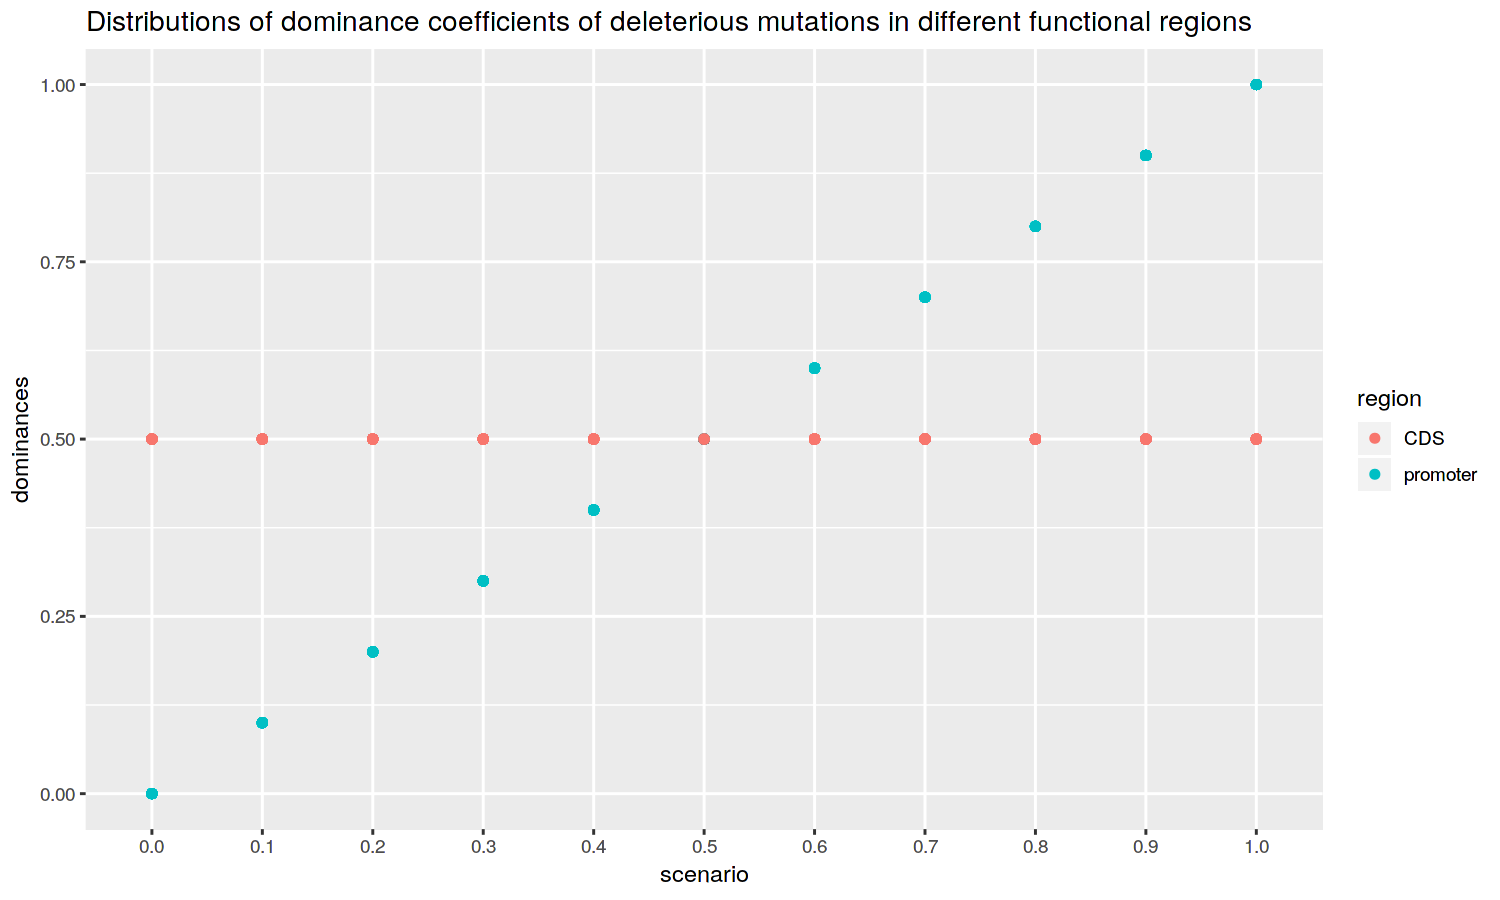

In [82]:
mut_dominances %>% sample_n(10000) %>% 
    ggplot(aes(scenario, dominances, color = region)) + geom_point() +
    ggtitle("Distributions of dominance coefficients of deleterious mutations in different functional regions")

## DFE of promoters differs

In [103]:
all_sites <- read_coordinates("../data/slim_coords/merged_all_sites.bed")

slim_merged <- read_coordinates("../data/slim_coords/merged_regions.bed")

real_promoters <- suppressMessages(read_tsv("../data/slim_coords/promoter_regions.bed")) %>% makeGRangesFromDataFrame(starts.in.df.are.0based = TRUE, keep.extra.columns = TRUE)
real_merged <- suppressMessages(read_tsv("../data/slim_coords/merged_regions.bed")) %>% makeGRangesFromDataFrame(starts.in.df.are.0based = TRUE, keep.extra.columns = TRUE)

hits <- findOverlaps(real_merged, real_promoters)

promoters <- slim_merged[queryHits(hits)]
cds <- slim_merged[slim_merged %outside% promoters]

In [84]:
sel <- c("0.0", "0.25", "0.5", "0.75", "1.0", "1.25", "1.5", "1.75", "2.0")

In [85]:
s_prom_cds <- future_map_dfr(sel, function(s) {
    
map_dfr(1:20, function(rep) {
    vcf_path <- glue("../data/simulations/merged_sel_{s}_rep_{rep}_gen_2200.vcf.gz")
    
    if (!file.exists(vcf_path)) return(NULL)

    vcf <- read_vcf(vcf_path)

    markers <- mut_gt(vcf, mut_type = 1) %>% fill_lost(all_sites)

    promoter_markers  <- markers[markers %within% promoters] %>% as.data.frame %>% mutate(rep = rep, bin = "promoter") %>% select(rep, freq, bin, starts_with("chr"))
    cds_markers  <- markers[markers %within% cds] %>% as.data.frame %>% mutate(rep = rep, bin = "cds") %>% select(rep, freq, bin, starts_with("chr"))
    gap_markers  <- markers[markers %outside% IRanges::union(cds, promoters)] %>% as.data.frame %>% mutate(rep = rep, bin = "gap") %>% select(rep, freq, bin, starts_with("chr"))

    bind_rows(promoter_markers, cds_markers, gap_markers)

}) %>%
    group_by(bin) %>%
    summarise_at(vars(starts_with("chr")), mean) %>%
    gather(chr, nea_prop, -bin) %>%
    ungroup %>% 
    mutate(bin = factor(bin), selection = s)

})

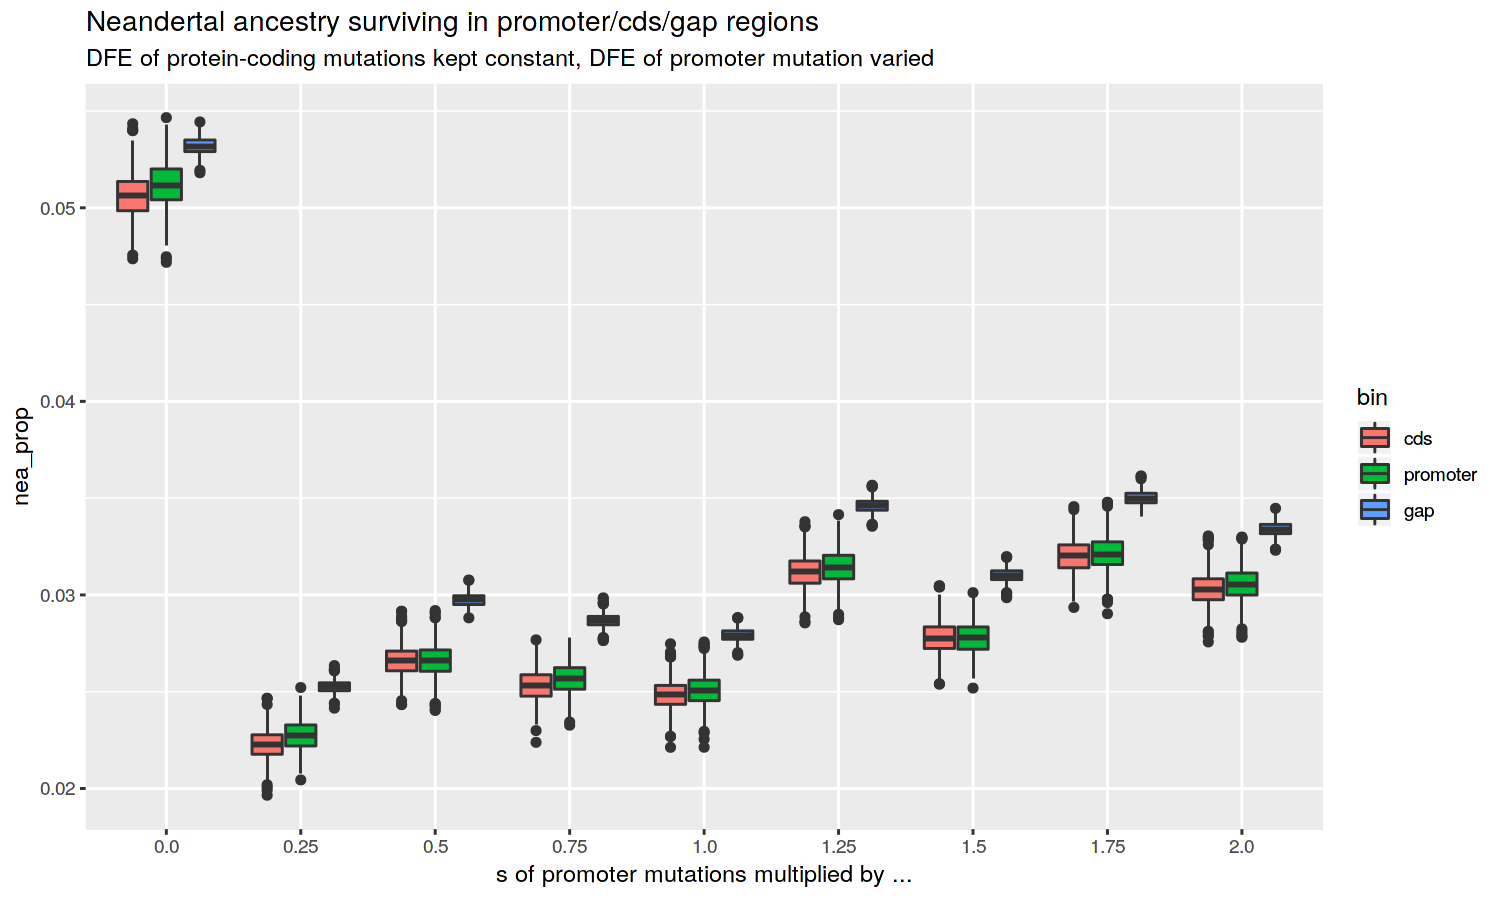

In [88]:
set_dim(10, 6)

s_prom_cds %>%
mutate(dominance = factor(selection),
       bin = factor(bin, levels = c("cds", "promoter", "gap"))) %>%
ggplot(aes(dominance, nea_prop, fill = bin)) + geom_boxplot() +
    xlab("s of promoter mutations multiplied by ...") +
    ggtitle("Neandertal ancestry surviving in promoter/cds/gap regions",
            "DFE of protein-coding mutations kept constant, DFE of promoter mutation varied")

Are there really differences in h of deleterious mutations between promoters and CDS (sanity check)?

In [126]:
mut_dfe <- future_map_dfr(sel, function(s) {
    slim_file <- read_slim(glue("../data/burnins/different_s_{s}_merged.txt"))
    muts <- read_mutations(slim_file) %>%
        filter(mut_type != "m1") %>%
        mutate(chrom = 1, start = pos - 1, end = pos) %>%
        makeGRangesFromDataFrame(starts.in.df.are.0based = TRUE, keep.extra.columns = TRUE)

    bind_rows(
        data.frame(scenario = s, log10s = log10(-muts[muts %over% cds]$s), region = "CDS"),
        data.frame(scenario = s, log10s = log10(-muts[muts %over% promoters]$s), region = "promoter")
    )
})

In [127]:
head(mut_dfe)

scenario,log10s,region
0.0,-3.858814,CDS
0.0,-6.562986,CDS
0.0,-4.241199,CDS
0.0,-6.705587,CDS
0.0,-5.209374,CDS
0.0,-8.658742,CDS


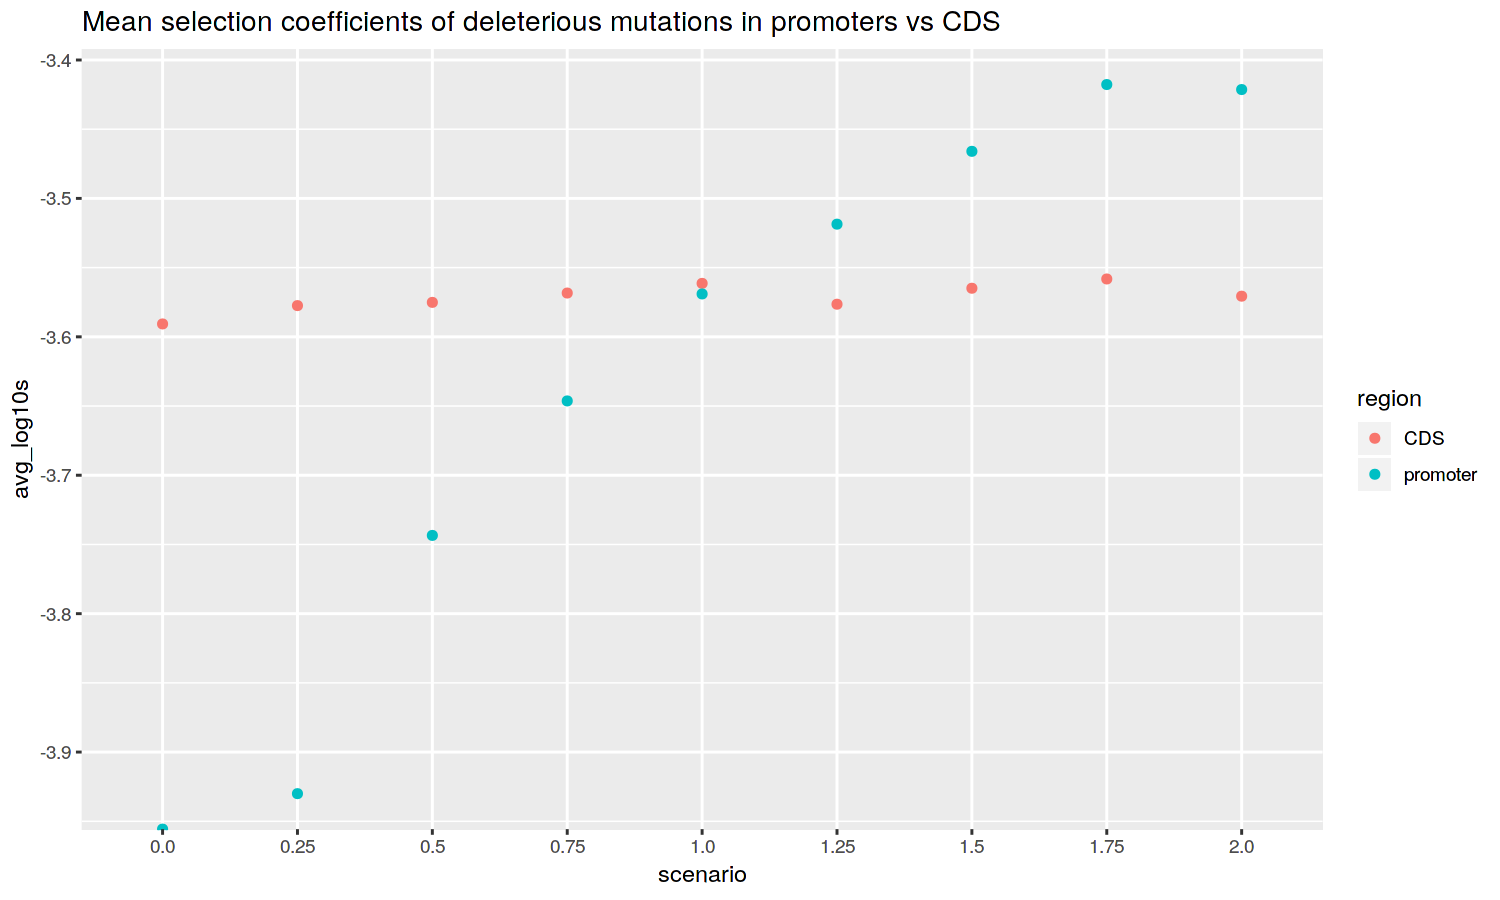

In [131]:
mut_dfe %>% group_by(scenario, region) %>% summarise(avg_log10s = mean(log10s)) %>% 
    ggplot(aes(scenario, avg_log10s, color = region)) + geom_point() +
    ggtitle("Mean selection coefficients of deleterious mutations in promoters vs CDS")